<a href="https://colab.research.google.com/github/JanMeow/GNN_StackedRF_3D_Spatial_DeepLearning/blob/main/GNN_StackedRF_Guess_the_GeometricType_Chapter_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stack Ensemble Appraoch

After confirming that training model with contextual features yield higher accuracy from already labelled cluster based on truth label.

We are now tackling real world problems where we treat the entire model as unlabelled

#🧠 Current Pipeline Summary
Step 1: Intrinsic features → Classify node (e.g., using logistic regression, RF, etc.)

Step 2: Use first prediction to build cluster-based contextual features

Step 3: Concatenate step 1's intrinsic features + contextual features → Final classification

In [1]:
# Getting the data and data engineering functions
!git clone https://github.com/JanMeow/3d_graph_data_engineering.git
# Install the dependency
!mv 3d_graph_data_engineering data_engineering
!pip install numpy pandas ifcopenshell

Cloning into '3d_graph_data_engineering'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 87 (delta 49), reused 61 (delta 23), pack-reused 0 (from 0)
Receiving objects: 100% (87/87), 323.93 KiB | 3.14 MiB/s, done.
Resolving deltas: 100% (49/49), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 3.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import ifcopenshell
import sys
sys.path.append('/content/data_engineering')
from data_engineering import collision as C, utils as U, compute_proxy as CP

In [3]:
from pathlib import Path
# lets use the test ifc_model
ifc_path = "/content/data_engineering/data/ifc/ML_train_data_0.ifc"

In [4]:
model = ifcopenshell.open(ifc_path)
root = model.by_type("IfcProject")[0]

In [5]:
from utils import  Graph
# Create a graph and establish BVH Tree=
graph = Graph.create(root)
graph.build_bvh()

Function ended, No more spatial child
Graph created


In [ ]:
#Build edges for graph
for node in graph.node_dict.values():
        if node.geom_info != None:
            node.near = [graph.node_dict[guid] for guid in graph.bvh_query(node.geom_info["bbox"])
                         if guid != node.guid]

In [7]:
#Get Intrisic features for all nodes
intrinsic_features = [CP.get_Intrinsic_features(graph, key) for key in graph.node_dict.keys()]
print("Finished Extracting Intrinsic Features")

Finished Extracting Intrinsic Features


In [11]:
targets = [node.geom_type for node in graph.node_dict.values()]

In [57]:
#Example of an intrisic features
df1 = pd.DataFrame(intrinsic_features)
df1['target'] = targets
df1.head()

,AABB_X_Extent,OOBB_X_Extent,AABB_Y_Extent,OOBB_Y_Extent,AABB_Z_Extent,OOBB_Z_Extent,AABB_base_area,OOBB_Base_area,World_X_Extent,World_Y_Extent,...,Volume,Largest_face_area,Largest_face_normal_has_Z_vector,Number_of_vertices_in_base,Number_of_vertices,Number_of_faces,Number_of_XYZ_aligned_faces,Number_of_Z_aligned_faces,Number_of_faces_in_largest_face,target
0,4.69,4.651975,6.78,6.953317,0.04,0.040000,15.94,32.35,27.68,13.68,...,0.659685,15.94,True,6,12,20,8,8,4,IfcSlab
1,1.98,0.280000,3.70,0.202695,0.28,4.058783,0.80,0.06,27.68,13.68,...,0.223608,1.12,False,4,8,12,4,4,2,IfcBeam
2,3.44,4.458813,3.08,0.199449,0.28,0.280000,0.87,0.89,27.68,13.68,...,0.244300,1.24,False,4,8,12,4,4,2,IfcBeam
3,4.18,3.491121,6.53,6.070073,0.04,0.040000,15.59,21.19,27.68,13.68,...,0.623736,15.59,True,5,10,16,6,6,3,IfcSlab
4,0.57,0.280000,1.78,0.206350,0.28,1.831194,0.33,0.06,27.68,13.68,...,0.092064,0.51,False,4,8,12,4,4,2,IfcBeam


In [12]:
#Models from SK-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

#Model Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

In [13]:
# Split Data into x and y
x = df1.drop('target', axis =1)
y = df1.target

In [18]:
from sklearn.preprocessing import LabelEncoder
le_step1 = LabelEncoder()
y_step1_encoded = le_step1.fit_transform(y)

In [19]:
np.random.seed(42)
# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y_step1_encoded, test_size=0.2)

In [20]:
# Some models like logistic regression perform better if features are scaled
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# Put models into a dictionray
models_0 = {
    'Logistic Regression' : make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier()),
    'Random Forest' : RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier()
}
#Create a function to fit and score models
def fit_and_score(models, x_train, x_test, y_train, y_test):
    '''
    Fit and evaluates given machine learning models.
    models: a dictionary of different SK learn models
    x_train : training data (no labels)
    x_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    '''

    #Set Random seed
    np.random.seed(42)
    #Make a dictionary to keep model scores
    output = {}
    # Loop through models
    for name, model in models.items():
        #Fit the model to the data
        model.fit(x_train, y_train)
        # Evaluate the model and append its score to the model_scores
        output[name] = {
        "scores":0,
        "y_preds": 0
        }
        output[name]["scores"] = model.score(x_test, y_test)
        output[name]["y_preds"] = model.predict(x_test)
    return output

In [21]:
output = fit_and_score(models_0, x_train, x_test, y_train, y_test)

In [23]:
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

ensemble = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier()),
        ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
    ],
    voting='soft'  # Use probabilities instead of hard voting
)
ensemble.fit(x_train, y_train)
ensemble_score = ensemble.score(x_test, y_test)
y_preds = ensemble.predict(x_test)
print(f"Ensemble Accuracy: {ensemble_score}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:19:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Ensemble Accuracy: 0.9523809523809523


{'Logistic Regression': 0.7936507936507936, 'KNN': 0.7936507936507936, 'Random Forest': 0.9206349206349206, 'XGBoost': 0.9047619047619048, 'Ensemble': 0.9523809523809523}


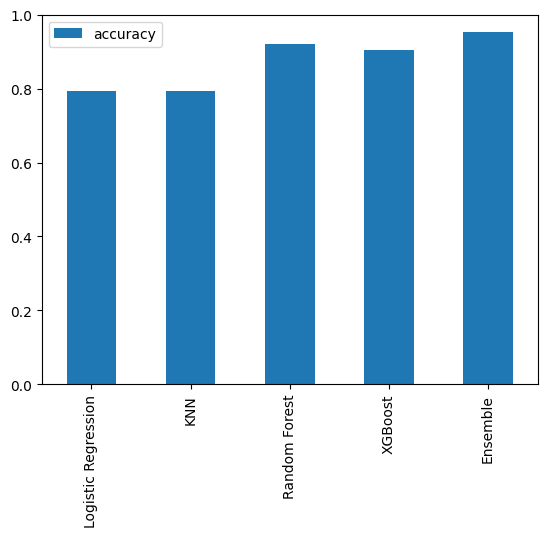

In [24]:
model_scores = {model:stats["scores"]for model, stats in output.items()} | {"Ensemble": ensemble_score}
print(model_scores)
model_compare = pd.DataFrame(model_scores, index = ['accuracy'])
model_compare.T.plot.bar();

In [29]:
#Use Ensemble model as the first intrisic labeller
probs = ensemble.predict_proba(x_test)
#Get top 3 indexes
top3_indices = np.argsort(probs, axis=1)[:, -3:][:, ::-1]  # shape: (n_samples, 3)

In [28]:
top3_indices[:5]

array([[7, 3, 2],
       [0, 7, 4],
       [7, 2, 3],
       [7, 3, 2],
       [7, 3, 2]])

In [35]:
#Impute the type as truth label
imputed_y_preds = top3_indices[:,0]
imputed_y_preds[:5]

array([7, 0, 7, 7, 7])

In [37]:
le_step1.inverse_transform(imputed_y_preds[:5])

array(['IfcWall', 'IfcBeam', 'IfcWall', 'IfcWall', 'IfcWall'],
      dtype=object)

In [60]:
import copy
#Instatiate a new graph
new_graph = copy.deepcopy(graph)
#rewrite the graph
for node, label in zip(new_graph.node_dict.values(), le_step1.inverse_transform(imputed_y_preds)):
  node.geom_type = label

In [61]:
# Get contextural_features (non-optimised version)
contextual_features = [CP.get_contextural_features(graph, key) for key in graph.node_dict.keys()]

In [62]:
df2 = pd.DataFrame(contextual_features)
df2

,upper,lower,left,right,number_of_neighbours_of_same_type,HR_None,HR_IfcWall,HR_IfcSlab,HR_IfcRoof,HR_IfcColumn,...,variances_of_orientation_Y,variances_of_orientation_Z,anisotropy_ratio,height_mean,height_var,width_mean,width_var,depth_mean,depth_var,z_alignment_consistency
0,None,IfcSlab,IfcSlab,IfcSlab,0,0,37,2,1,0,...,0.0,0.0,0.0,0.040000,0.0,6.953317,0.0,4.651975,0.0,1.0
1,None,IfcBeam,IfcBeam,IfcBeam,0,0,37,9,1,0,...,0.0,0.0,0.0,4.058783,0.0,0.280000,0.0,0.202695,0.0,0.0
2,None,IfcBeam,IfcBeam,IfcBeam,0,0,37,9,1,0,...,0.0,0.0,0.0,0.280000,0.0,4.458813,0.0,0.199449,0.0,1.0
3,None,IfcSlab,IfcSlab,IfcSlab,0,0,38,2,0,3,...,0.0,0.0,0.0,0.040000,0.0,6.070073,0.0,3.491121,0.0,1.0
4,None,IfcBeam,IfcBeam,IfcBeam,0,0,37,4,0,1,...,0.0,0.0,0.0,1.831194,0.0,0.280000,0.0,0.206350,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,None,IfcColumn,IfcColumn,IfcColumn,0,0,37,0,0,3,...,0.0,0.0,0.0,2.600000,0.0,0.200000,0.0,0.200000,0.0,1.0
308,None,IfcColumn,IfcColumn,IfcColumn,0,0,39,0,0,9,...,0.0,0.0,0.0,2.720000,0.0,0.200000,0.0,0.200000,0.0,1.0
309,None,IfcCurtainWall,IfcCurtainWall,IfcCurtainWall,0,0,31,0,1,3,...,0.0,0.0,0.0,10.060000,0.0,5.180000,0.0,0.070000,0.0,1.0
310,None,IfcColumn,IfcColumn,IfcColumn,0,0,37,4,0,7,...,0.0,0.0,0.0,5.640000,0.0,0.200000,0.0,0.200000,0.0,1.0


In [63]:
#Manually label data
label_map = {
    "None": 0,
    "IfcWall": 1,
    "IfcSlab": 2,
    "IfcRoof": 3,
    "IfcColumn": 4,
    "IfcBeam": 5,
    "IfcCurtainWall": 6,
    "IfcFooting": 7,
    "IfcPlate": 8
}
inv_map = {v: k for k, v in label_map.items()}

In [64]:
#Label the upper,lower,right,left column
cols = ["upper", "lower", "left", "right"]
for col in cols:
  df2[col] = df2[col].fillna("None")
  df2[col] = df2[col].map(label_map)
df2.head(4)

,upper,lower,left,right,number_of_neighbours_of_same_type,HR_None,HR_IfcWall,HR_IfcSlab,HR_IfcRoof,HR_IfcColumn,...,variances_of_orientation_Y,variances_of_orientation_Z,anisotropy_ratio,height_mean,height_var,width_mean,width_var,depth_mean,depth_var,z_alignment_consistency
0,0,2,2,2,0,0,37,2,1,0,...,0.0,0.0,0.0,0.040000,0.0,6.953317,0.0,4.651975,0.0,1.0
1,0,5,5,5,0,0,37,9,1,0,...,0.0,0.0,0.0,4.058783,0.0,0.280000,0.0,0.202695,0.0,0.0
2,0,5,5,5,0,0,37,9,1,0,...,0.0,0.0,0.0,0.280000,0.0,4.458813,0.0,0.199449,0.0,1.0
3,0,2,2,2,0,0,38,2,0,3,...,0.0,0.0,0.0,0.040000,0.0,6.070073,0.0,3.491121,0.0,1.0


In [65]:
df1 = df1.drop("target", axis =1)
df_combined = pd.concat([df1, df2], axis=1)
df_combined

,AABB_X_Extent,OOBB_X_Extent,AABB_Y_Extent,OOBB_Y_Extent,AABB_Z_Extent,OOBB_Z_Extent,AABB_base_area,OOBB_Base_area,World_X_Extent,World_Y_Extent,...,variances_of_orientation_Y,variances_of_orientation_Z,anisotropy_ratio,height_mean,height_var,width_mean,width_var,depth_mean,depth_var,z_alignment_consistency
0,4.69,4.651975,6.78,6.953317,0.04,0.040000,15.94,32.35,27.68,13.68,...,0.0,0.0,0.0,0.040000,0.0,6.953317,0.0,4.651975,0.0,1.0
1,1.98,0.280000,3.70,0.202695,0.28,4.058783,0.80,0.06,27.68,13.68,...,0.0,0.0,0.0,4.058783,0.0,0.280000,0.0,0.202695,0.0,0.0
2,3.44,4.458813,3.08,0.199449,0.28,0.280000,0.87,0.89,27.68,13.68,...,0.0,0.0,0.0,0.280000,0.0,4.458813,0.0,0.199449,0.0,1.0
3,4.18,3.491121,6.53,6.070073,0.04,0.040000,15.59,21.19,27.68,13.68,...,0.0,0.0,0.0,0.040000,0.0,6.070073,0.0,3.491121,0.0,1.0
4,0.57,0.280000,1.78,0.206350,0.28,1.831194,0.33,0.06,27.68,13.68,...,0.0,0.0,0.0,1.831194,0.0,0.280000,0.0,0.206350,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,0.20,0.200000,0.20,0.200000,2.60,2.600000,0.04,0.04,27.68,13.68,...,0.0,0.0,0.0,2.600000,0.0,0.200000,0.0,0.200000,0.0,1.0
308,0.20,0.200000,0.20,0.200000,2.72,2.720000,0.04,0.04,27.68,13.68,...,0.0,0.0,0.0,2.720000,0.0,0.200000,0.0,0.200000,0.0,1.0
309,0.07,0.070000,5.18,5.180000,10.06,10.060000,0.36,0.36,27.68,13.68,...,0.0,0.0,0.0,10.060000,0.0,5.180000,0.0,0.070000,0.0,1.0
310,0.20,0.200000,0.20,0.200000,5.64,5.640000,0.04,0.04,27.68,13.68,...,0.0,0.0,0.0,5.640000,0.0,0.200000,0.0,0.200000,0.0,1.0


In [70]:
np.random.seed(42)
# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(df_combined, y_step1_encoded, test_size=0.2)

In [67]:
models_2 = {
    'Logistic Regression' : make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier()),
    'Random Forest' : RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier()
}
output = fit_and_score(models_2, x_train, x_test, y_train, y_test)

{'Logistic Regression': 0.9841269841269841, 'KNN': 0.9682539682539683, 'Random Forest': 1.0, 'XGBoost': 0.9682539682539683}


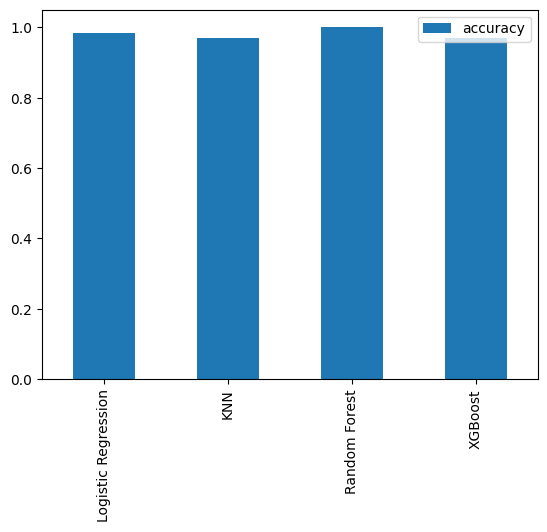

In [68]:
model_scores = {model:stats["scores"]for model, stats in output.items()}
print(model_scores)
model_compare = pd.DataFrame(model_scores, index = ['accuracy'])
model_compare.T.plot.bar();

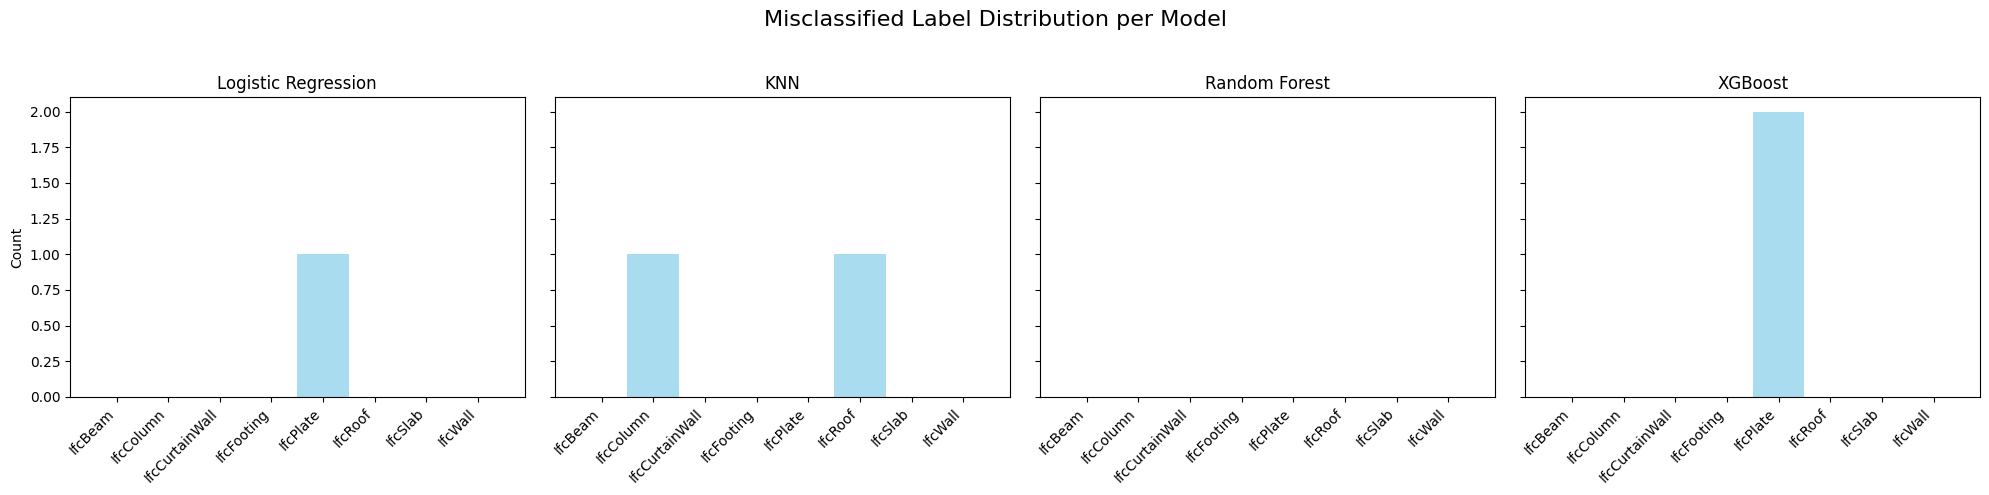

In [69]:
import matplotlib.pyplot as plt

num_models = len(output)
fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 5), sharey=True)

for ax, (model_name, model_stats) in zip(axes, output.items()):
    y_preds = model_stats["y_preds"]
    missed_idx = np.where(y_preds != y_test)[0]
    missed_labels = y_test[missed_idx]

    ax.hist(missed_labels, bins=np.arange(len(le_step1.classes_) + 1) - 0.5, alpha=0.7, color='skyblue')
    ax.set_title(f"{model_name}")
    ax.set_xticks(np.arange(len(le_step1.classes_)))
    ax.set_xticklabels(le_step1.classes_, rotation=45, ha='right')

axes[0].set_ylabel("Count")
fig.suptitle("Misclassified Label Distribution per Model", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()